In [1]:
import torch
import torch.nn.functional as F
import plotly.graph_objects as go
import matplotlib.pyplot as plt
%matplotlib inline

In [19]:
from urllib.request import urlopen
lines = urlopen('https://raw.githubusercontent.com/jjgold012/nlp_stuff/main/data/names.txt').read().splitlines()
words = [l.decode('utf-8') for l in lines]

chrs = ['.'] + sorted(list(set(''.join(words))))
chrs_to_idx = {c: i for i,c in enumerate(chrs)}
idx_to_chrs = {i: c for i,c in enumerate(chrs)}
num_of_chrs = len(chrs)
print(chrs, num_of_chrs)

['.', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z'] 27


# Bigram

In [20]:
bigrams = torch.zeros(len(chrs),len(chrs), dtype=torch.int16)
for w in words:
    w_chrs = ['.'] + list(w) + ['.']
    for b in zip(w_chrs, w_chrs[1:]):
        bigrams[chrs_to_idx[b[0]], chrs_to_idx[b[1]]] += 1


In [8]:

# plt.figure(figsize=(16,16))
# plt.imshow(bigrams, cmap='Blues')
# for i,j in [(i,j) for i in range(len(chrs)) for j in range(len(chrs))]:
#     plt.text(j,i, idx_to_chrs[i]+idx_to_chrs[j],ha='center', va='bottom')
#     plt.text(j,i, bigrams[i,j].item(),ha='center', va='top')


In [21]:
g = torch.Generator().manual_seed(2147483647)
prob = bigrams / bigrams.sum(dim=1, keepdim=True)

def gen():
    i = 0
    w = []
    while True:
        i = torch.multinomial(prob[i], num_samples=1, replacement=True, generator=g).item()
        if i == 0:
            break
        w.append(idx_to_chrs[i])
        
    return ''.join(w) 

for i in range(5):
    print(gen())    

junide
janasah
p
cony
a


## loglikelihood loss


In [22]:
ll = 0.
n = 0
for w in words:
    w_chrs = ['.'] + list(w) + ['.']
    for b in zip(w_chrs, w_chrs[1:]):
        ll += torch.log(prob[chrs_to_idx[b[0]], chrs_to_idx[b[1]]])
        n += 1

print("minus log likelihood: ", -ll / n)


minus log likelihood:  tensor(2.4541)


## single layer neural net equivalent

In [23]:
xs = []
ys=[]
for w in words:
    w_chrs = ['.'] + list(w) + ['.']
    for b in zip(w_chrs, w_chrs[1:]):
        xs.append(chrs_to_idx[b[0]]) 
        ys.append(chrs_to_idx[b[1]])

xs = torch.tensor(xs)
ys = torch.tensor(ys)


### train loop

In [24]:

g = torch.Generator().manual_seed(2147483647)

W = torch.randn((num_of_chrs, num_of_chrs), generator=g, requires_grad=True)
print(xs.shape, num_of_chrs)
x_enc = F.one_hot(xs, num_classes=num_of_chrs).float()


torch.Size([228146]) 27


In [25]:
for i in range(5000):
    logits = x_enc @ W
    counts = logits.exp()
    prob = counts / counts.sum(dim=1, keepdim=True)
    loss = -prob[torch.arange(ys.shape[0]), ys].log().mean()
    if i%100==0: print(i, loss.item())

    # backward pass
    W.grad = None
    loss.backward()

    # update weights
    W.data -= 10 * W.grad

0 3.758953332901001
100 2.5751142501831055
200 2.5094540119171143
300 2.4884207248687744
400 2.4785091876983643
500 2.4727985858917236
600 2.4691412448883057
700 2.466632127761841
800 2.4648189544677734
900 2.463451385498047
1000 2.4623842239379883
1100 2.4615273475646973
1200 2.4608237743377686
1300 2.460235357284546
1400 2.459735870361328
1500 2.4593067169189453
1600 2.4589343070983887
1700 2.4586076736450195
1800 2.4583194255828857
1900 2.4580636024475098
2000 2.4578351974487305
2100 2.457629680633545
2200 2.4574437141418457
2300 2.457275152206421
2400 2.4571218490600586
2500 2.4569814205169678
2600 2.456852674484253
2700 2.4567339420318604
2800 2.4566240310668945
2900 2.4565224647521973
3000 2.456428050994873
3100 2.4563398361206055
3200 2.4562578201293945
3300 2.456181049346924
3400 2.456108808517456
3500 2.4560413360595703
3600 2.455977201461792
3700 2.4559175968170166
3800 2.4558606147766113
3900 2.4558067321777344
4000 2.4557559490203857
4100 2.4557080268859863
4200 2.455662250

In [26]:
logits = x_enc @ W
counts = logits.exp()
prob = counts / counts.sum(dim=1, keepdim=True)
loss = -prob[torch.arange(ys.shape[0]), ys].log().mean()
print("all:", loss.item())

all: 2.45536470413208


In [27]:
g = torch.Generator().manual_seed(2147483647)
def gen2():
    i = 0
    w = []
    while True:
        logits = F.one_hot(torch.tensor(i), num_classes=len(idx_to_chrs)).float() @ W
        prob = logits.softmax(dim=0)
        i = torch.multinomial(prob, num_samples=1, replacement=True, generator=g).item()
        if i == 0:
            break
        w.append(idx_to_chrs[i])
        
    return ''.join(w) 

for i in range(5):
    print(gen2())   

junide
janasah
p
cony
a


# MLP

simple

In [28]:

def build_dataset(ws, context_size):
    xs = []
    ys = []
    for w in ws:
        w_chrs = list(w) + ['.']
        context = [0]*context_size
        for c in w_chrs:
            xs.append(context) 
            ys.append(chrs_to_idx[c])
            context = context[1:] + [chrs_to_idx[c]]

    xs = torch.tensor(xs)
    ys = torch.tensor(ys)
    return xs, ys

context_size = 3
i = int(0.8*len(words))
j = int(0.9*len(words))

import random
random.seed(7)
random.shuffle(words)

xs, ys = build_dataset(words, context_size)
xs_train, ys_train = build_dataset(words[:i], context_size)
xs_dev, ys_dev = build_dataset(words[i:j], context_size)
xs_test, ys_test = build_dataset(words[j:], context_size)
print(xs_train.shape[0], xs_dev.shape[0], xs_test.shape[0])


182534 22760 22852


In [ ]:
g = torch.Generator().manual_seed(2147483647)

embed_dim = 5
n_hidden = 500
C = torch.randn((num_of_chrs, embed_dim))
W1 = torch.randn((embed_dim*context_size, n_hidden ))*0.2
b1 = torch.randn(W1.shape[1])*0.01
W2 = torch.randn((W1.shape[1], num_of_chrs))*0.01
b2 = torch.randn(W2.shape[1])*0
parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True
print(sum(p.nelement() for p in parameters))

with torch.no_grad():
    embed = C[xs_dev]
    m_pre_act = embed.view((embed.shape[0], -1)) @ W1 + b1
    m = torch.tanh(m_pre_act)
    logits = m @ W2 + b2
    loss = F.cross_entropy(logits, ys_dev)
    print(loss.item())
    plt.hist(m.view(-1).tolist(), 50)
    plt.show()
    plt.hist(m_pre_act.view(-1).tolist(), 50)
    plt.show()
    plt.figure(figsize=(50,10))
    plt.imshow(m.abs()>0.99,cmap='gray', interpolation='nearest')
    plt.show()
# test_params()

21662


In [ ]:
batch_size = 60

lossi = []
# lre = torch.linspace(-3,0,1000)
# lrii = 10**lre

def batch_forward(x,y):
    emb = C[x]
    m = torch.tanh(emb.view((emb.shape[0], -1)) @ W1 + b1)
    logits = m @ W2 + b2
    return F.cross_entropy(logits, y)



for i in range(400000):
    # batch
    idx = torch.randint(0, xs_train.shape[0], (batch_size,))
    x = xs_train[idx]
    y = ys_train[idx]
    
    # forward
    loss = batch_forward(x,y)

    # backwards
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    def lr():
        if i<200000: return  1e-1
        elif i<300000: return 1e-2
        else: return 1e-3
    lri = lr()
    for p in parameters:
        p.data += -lri * p.grad

    lossi.append(loss.log10().item())
    if i % 1000 == 0: print(i, loss.item())
    


0 3.2655346393585205
1000 2.2944958209991455
2000 2.499225378036499
3000 2.3313775062561035
4000 2.10540509223938
5000 2.297152280807495
6000 2.531853675842285
7000 2.3293163776397705
8000 2.2992899417877197
9000 2.3347549438476562
10000 2.6640679836273193
11000 1.8616371154785156
12000 2.454564332962036
13000 2.2742693424224854
14000 2.308377504348755
15000 2.075568437576294
16000 2.3326659202575684
17000 2.291686773300171
18000 2.219526767730713
19000 2.1241185665130615
20000 2.1274919509887695
21000 2.0211551189422607
22000 2.2954092025756836
23000 2.2583038806915283
24000 1.9602590799331665
25000 2.294100284576416
26000 2.319150447845459
27000 2.2040250301361084
28000 2.1496734619140625
29000 2.025085687637329
30000 2.169390916824341
31000 2.354123830795288
32000 1.9640159606933594
33000 2.129279136657715
34000 1.9911309480667114
35000 2.3024656772613525
36000 2.5586397647857666
37000 2.2777657508850098
38000 2.2519872188568115
39000 2.1964404582977295
40000 2.0083813667297363
4100

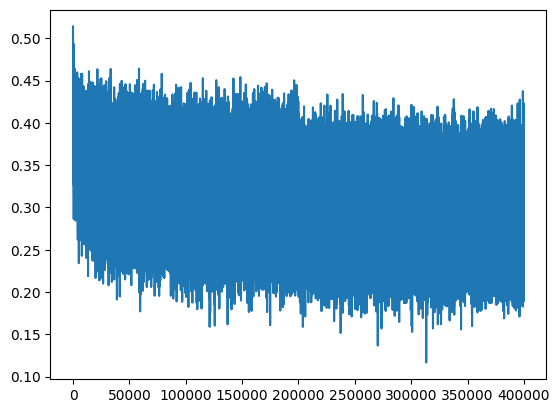

In [ ]:
plt.plot(lossi)

In [ ]:
@torch.no_grad()
def calc_loss(x,y):
    
    emb = C[x]
    m = torch.tanh(emb.view(emb.shape[0], -1) @ W1 + b1)
    logits = m @ W2 + b2
    return F.cross_entropy(logits, y)
loss = calc_loss(xs, ys)
print("all:", loss.item())
loss = calc_loss(xs_train, ys_train)
print("train:", loss.item())
loss = calc_loss(xs_dev, ys_dev)
print("dev:", loss.item())


all: 2.018998861312866
train: 1.9995982646942139
dev: 2.092005729675293


In [ ]:
loss = calc_loss(xs_test, ys_test)
print("test:", loss.item())

test: 2.101776361465454


In [ ]:
num_C = C.detach().numpy()
print(num_C.shape)
print(num_C[:,0])
f = go.Figure(go.Scatter3d(x=num_C[:,0],y=num_C[:,1],z=num_C[:,2], text=chrs, mode="markers"))
f.show()

(27, 3)
[-0.21051629  0.4651135   0.9678167   1.5283791  -0.03549856  0.22370246
  0.05884338  0.26314777  0.0165347  -0.04325281 -0.12550206 -0.00277822
 -0.5669253  -0.17700806 -0.41221038  0.2925384   0.18332364 -0.6108084
 -0.29116392 -0.01535065  0.02738359  0.16958687 -0.21189423 -0.00622117
  1.1273987  -0.2924037  -0.13241486]


In [ ]:
g = torch.Generator().manual_seed(2147483647)

def gen3():
    context = [0]*context_size
    w = []
    while True:
        emb = C[context]
        m = torch.tanh(emb.view((emb.shape[0], -1)) @ W1 + b1)
        logits = m @ W2 + b2
        prob = logits.softmax(dim=1)
        # print(prob)
        idx = torch.multinomial(prob, num_samples=1, replacement=True, generator=g).item()
        context = context[1:] + [idx]
        if idx == 0:
            break
        w.append(idx_to_chrs[idx])
        
    return ''.join(w) 

for i in range(10):
    print(gen3())   

junide
jakarie
presay
adria
jirrito
sabe
ter
kalania
yani
eveah
deyah
roy
tayse
sinayla
ter
nouumeryfontavi
phyne
jah
jaylie
raaya


# Define layers

In [ ]:
from typing import Any


class Linear:
    def __init__(self, in_dim, out_dim, bias=True) -> None:
        self.W = torch.randn(in_dim, out_dim) / in_dim**0.5
        self.b = torch.zeros(out_dim) if bias else None

    def __call__(self, x) -> torch.Tensor:
        self.out = x @ self.W
        if self.b is not None:
            self.out += self.b
        return self.out

    def parameters(self):
        return [self.W] + [self.b] if self.b is not None else []


class Tanh:
    def __call__(self, x) -> torch.Tensor:
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []


class BatchNorm2d:
    def __init__(
        self, in_dim, epsilon=1e-5, momentum=0.1, track_running_stats=True
    ) -> None:
        self.epsilon = epsilon
        self.momentum = momentum
        self.gamma = torch.ones(in_dim)
        self.b = torch.zeros(in_dim)
        self.training = True
        self.running_mean = torch.zeros(in_dim)
        self.running_var = torch.ones(in_dim)

    def __call__(self, x: torch.Tensor) -> torch.Tensor:
        x_mean = x.mean(0, keepdim=True) if self.training else self.running_mean
        x_var = x.var(0, keepdim=True) if self.training else self.running_var
        x_hat = (x - x_mean) / torch.sqrt(x_var + self.epsilon)
        self.out = self.gamma * x_hat + self.b
        if self.training:
            with torch.no_grad():
                self.running_mean = (
                    1 - self.momentum
                ) * self.running_mean + self.momentum * x_mean
                self.running_var = (
                    1 - self.momentum
                ) * self.running_var + self.momentum * x_var
        return self.out

    def parameters(self):
        return [self.W] + [self.b] if self.b is not None else []


class Emb:
    def __init__(self, num_of_types, emb_dim) -> None:
        self.C = torch.randn(num_of_types, emb_dim)

    def __call__(self, x_idx) -> Any:
        self.out = self.C[x_idx]
        return self.out
    def parameters(self):
        return [self.C] 


class Flatten:
    def __call__(self, x) -> Any:
        self.out = x.view(x.shape[0], -1)
        return self.out
    def parameters(self):
        return []



In [ ]:
g = torch.Generator().manual_seed(2147483647)

embed_dim = 5
n_hidden = 500
C = torch.randn((num_of_chrs, embed_dim))
W1 = torch.randn((embed_dim*context_size, n_hidden ))*0.2
b1 = torch.randn(W1.shape[1])*0.01
W2 = torch.randn((W1.shape[1], num_of_chrs))*0.01
b2 = torch.randn(W2.shape[1])*0
parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True
print(sum(p.nelement() for p in parameters))

with torch.no_grad():
    embed = C[xs_dev]
    m_pre_act = embed.view((embed.shape[0], -1)) @ W1 + b1
    m = torch.tanh(m_pre_act)
    logits = m @ W2 + b2
    loss = F.cross_entropy(logits, ys_dev)
    print(loss.item())
    plt.hist(m.view(-1).tolist(), 50)
    plt.show()
    plt.hist(m_pre_act.view(-1).tolist(), 50)
    plt.show()
    plt.figure(figsize=(50,10))
    plt.imshow(m.abs()>0.99,cmap='gray', interpolation='nearest')
    plt.show()
# test_params()


batch_size = 60

lossi = []
# lre = torch.linspace(-3,0,1000)
# lrii = 10**lre

def batch_forward(x,y):
    emb = C[x]
    m = torch.tanh(emb.view((emb.shape[0], -1)) @ W1 + b1)
    logits = m @ W2 + b2
    return F.cross_entropy(logits, y)



for i in range(400000):
    # batch
    idx = torch.randint(0, xs_train.shape[0], (batch_size,))
    x = xs_train[idx]
    y = ys_train[idx]
    
    # forward
    loss = batch_forward(x,y)

    # backwardsatch_size = 60

lossi = []
# lre = torch.linspace(-3,0,1000)
# lrii = 10**lre

def batch_forward(x,y):
    emb = C[x]
    m = torch.tanh(emb.view((emb.shape[0], -1)) @ W1 + b1)
    logits = m @ W2 + b2
    return F.cross_entropy(logits, y)



for i in range(400000):
    # batch
    idx = torch.randint(0, xs_train.shape[0], (batch_size,))
    x = xs_train[idx]
    y = ys_train[idx]
    
    # forward
    loss = batch_forward(x,y)

    # backwards
batch_size = 60

lossi = []
# lre = torch.linspace(-3,0,1000)
# lrii = 10**lre

def batch_forward(x,y):
    emb = C[x]
    m = torch.tanh(emb.view((emb.shape[0], -1)) @ W1 + b1)
    logits = m @ W2 + b2
    return F.cross_entropy(logits, y)



for i in range(400000):
    # batch
    idx = torch.randint(0, xs_train.shape[0], (batch_size,))
    x = xs_train[idx]
    y = ys_train[idx]
    
    # forward
    loss = batch_forward(x,y)

    # backwards